In [16]:
using GraphPPL
using Rocket
using ReactiveMP
using Distributions
using Plots
using LinearAlgebra
using Random
using JLD
using Parameters
import ProgressMeter

In [17]:
data_seed, params_seed = 42, 120

(42, 120)

In [18]:
import ReactiveMP.messageout

In [19]:
include("../helpers/data.jl")

generate_data

In [20]:
melu(x) = clamp(x, tiny, Inf)

melu (generic function with 1 method)

In [21]:
# order = 1
Y = zeros(3); Y[1] = 1.0;
U = zeros(3); U[2] = 1.0;
H = zeros(3); H[3] = 1.0;

In [22]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max(n, model_flow::FlowModel, params, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

    # Extract parameters for flow, neural network and Gamma
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_w = params[end-1:end]
    
    # initialize variables
    h       = randomvar(n)
    hy      = randomvar(n)
    hyu     = randomvar(n)
    θ       = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(0.0, 1e12))}  
    w       = randomvar() where {form_constraint = FixedMarginalConstraint(GammaShapeRate(melu(params_w[1]), melu(params_w[2])))}
    y       = datavar(Float64, n)

    ar_nodes = Vector{FactorNode}(undef, n)
    y_nodes = Vector{FactorNode}(undef, n)

    y_lat_1 = randomvar(n)
    y_lat_2 = randomvar(n)
    y_lat_3 = randomvar(n)
    
    Ys = [Y*y_prev[i] for i in 1:n]
    Us = [U*u[i] for i in 1:n]

    # create meta for AR
    AR_meta = ARMeta(Univariate, 1, ARsafe())
    # create meta compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])

    θ   ~ NormalMeanPrecision(0.0, 1e12)
    w   ~ GammaShapeRate(melu(params_w[1]), melu(params_w[2]))
    
    h_prev = h_0
    for t in 1:n
        # specify latent state
        ar_nodes[t], h[t] ~ AR(h_prev, θ, w) where {q = q(y, x)q(γ)q(θ), meta = AR_meta}
        hy[t] ~ H*h[t] + Ys[t]
        hyu[t] ~ hy[t] + Us[t]
        y_lat_1[t] ~ Flow(hyu[t]) where { meta = Flow_meta}
        y_lat_2[t] ~ dot(y_lat_1[t], ones(dimension*3))
        y_nodes[t], y[t] ~ NormalMeanPrecision(y_lat_2[t], w)
        h_prev = h[t]
    end

    return h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes
end

nonlinear_max (generic function with 1 method)

In [44]:
function nonlinear_max_inference(observations, observations_prev, controls, model_flow::FlowModel, params; 
                                 h_prior=(0.0, 0.1), vmp_its=10)
    # fetch number of samples
    n = length(observations)

    # define model
    model, (h, hy, hyu, θ, w, y_lat_1, y_lat_2, y, y_nodes) = nonlinear_max(n, model_flow, params, h_prior,
                                                                       observations_prev, controls,
                                                                       options = (limit_stack_depth = 500, ))
    
    h_buffer = Vector{Marginal}(undef, n)
    hy_buffer = Vector{Marginal}(undef, n)
    hyu_buffer = Vector{Marginal}(undef, n)
    θ_buffer = Vector{Marginal}(undef, n)
    y_out_buffer = Vector{AbstractMessage}(undef, n)
    w_buffer = nothing
    
    h_sub = subscribe!(getmarginals(h), (x) -> copyto!(h_buffer, x))
    hy_sub = subscribe!(getmarginals(h), (x) -> copyto!(hy_buffer, x))
    w_sub = subscribe!(getmarginal(w), (x) -> w_buffer = x)
    θ_sub = subscribe!(getmarginal(θ), (x) -> θ_buffer = x)
    y_out_sub = subscribe!(collectLatest(messageout.(ReactiveMP.getinterface.(y_nodes, :out))), 
                                         (x) -> copyto!(y_out_buffer, ReactiveMP.as_message.(x)))
    
    # initialize free energy
    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))

    setmarginal!(w, GammaShapeRate(1.0, 1.0))
    setmarginal!(θ, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y, observations)
    end
    
    # unsubscribe
    unsubscribe!(fe_sub)
    unsubscribe!(h_sub)
    unsubscribe!(w_sub)
    unsubscribe!(θ_sub)
    
    # return the marginal values
    return fe_buffer, h_buffer, hy_buffer, hyu_buffer, w_buffer, y_out_buffer, θ_buffer
    
end

nonlinear_max_inference (generic function with 1 method)

In [24]:
# specify flow model
dimension = 3
model_flow = FlowModel(dimension,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow())
    )
);

In [25]:
Random.seed!(data_seed)

n_samples = 1000
u = 3 .* sin.(collect(1:n_samples+10))
y_lat, y_obs, h_gen = generate_data(n_samples, narx, Dict(:order_y=>1, :order_u=>1, :order_e=>1),
                                                     Dict(:er_var=>1e-2, :u=>u));

In [26]:
observations_prev = y_obs[1:end-1]
observations      = y_obs[2:end];
controls          = u[1:end];

In [27]:
train_size = 800
X_train, Y_train, U_train = observations_prev[1:train_size], observations[1:train_size], controls[1:train_size]
X_test, Y_test, U_test = observations_prev[train_size+1:end], observations[train_size+1:end], controls[train_size+1:end];

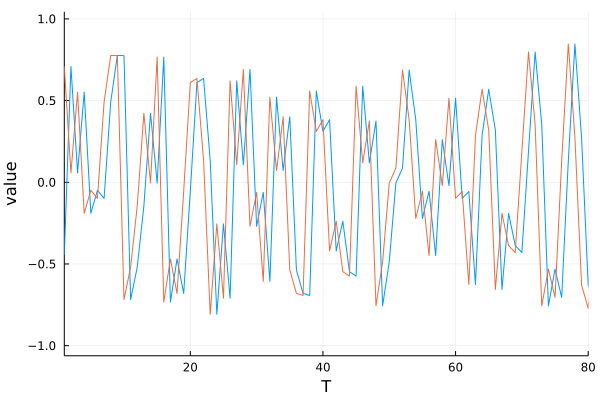

In [28]:
from, to = 1, 80
plot(y_obs, xlims=(1, train_size))
plot!(Y_train, xlims=(from, to), xlabel="T", ylabel="value", legend=false)

In [29]:
Random.seed!(params_seed)

flow_param_len = nr_params(model_flow)
model_params = [randn(flow_param_len); [0.1, 1.0]];

In [38]:
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, model_params, vmp_its=5);


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


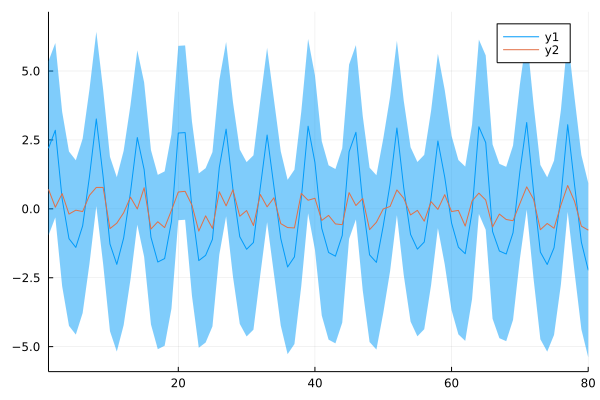

In [39]:
plot(mean.(y_out_), ribbon=sqrt.(cov.(y_out_)))
plot!(Y_train, xlims=(1, 80))

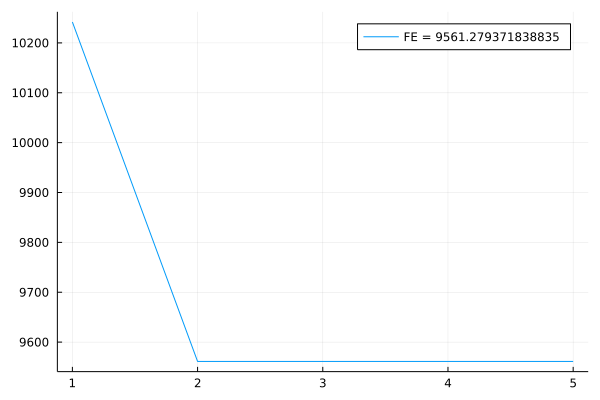

In [40]:
gr()
plot(fe_, label="FE = $(fe_[end])")

In [45]:
# Optimization function
function FE(params)
    fe, h, hy, hyu, w, y_out, θ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, params, 
                                                 h_prior=(0.0, 0.1), 
                                                 vmp_its=5)
    return fe[end]
end;

In [42]:
FE(model_params)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


9561.279371838835

In [ ]:
# unpack if you don't want to run Optim
@unpack inf_params = JLD.load("../dump/flow_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld")

In [104]:
import ReactiveMP.fastcholesky
using PositiveFactorizations

function ReactiveMP.fastcholesky(mat::AbstractMatrix)
    return cholesky(PositiveFactorizations.Positive, Hermitian(mat))
end

In [46]:
using Optim
res = optimize(FE, model_params, LBFGS(), Optim.Options(g_tol = 1e-8, iterations = 1000, store_trace = true, show_trace = true, show_every=10), autodiff=:forward)


Iter     Function value   Gradient norm 
     0     9.561279e+03     7.782400e+04
 * time: 0.00011420249938964844
    10     3.461263e+03     1.024000e+03
 * time: 114.19599199295044
    20     2.835124e+03     2.720000e+02
 * time: 564.5539710521698
    30     2.714599e+03     6.080625e+02
 * time: 938.3424851894379
    40     2.283930e+03     1.632250e+03
 * time: 1411.4734251499176
    50     1.871825e+03     2.564656e+03
 * time: 1544.98668217659
    60     1.773780e+03     1.024000e+03
 * time: 1984.4275600910187
    70     1.699235e+03     3.428000e+03
 * time: 2111.6912171840668
    80     1.690742e+03     1.638400e+04
 * time: 2330.2135961055756


 * Status: success

 * Candidate solution
    Final objective value:     1.690742e+03

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.64e+04 ≰ 1.0e-08

 * Work counters
    Seconds run:   2398  (vs limit Inf)
    Iterations:    81
    f(x) calls:    877
    ∇f(x) calls:   877


In [47]:
inf_params = Optim.minimizer(res)


20-element Vector{Float64}:
  -1.7454541386879452
   1.9783149612480126
   0.07500939610129924
  -0.5915282661989472
   1.0230315248216535
   2.82458021404712
   1.0633662556527654
   0.04353345820212854
   3.3972872684292224
   0.28368895578367104
  -0.6844211744777666
  -0.090267381013864
  -1.5462817107038105
 892.6220250278163
  -1.4582961605328868
   3.2398009698309442
  -1.5831610018152509
  -1.032138391792381
   2.738397518029427
   4.42297445996289

In [48]:
using JLD
JLD.save("../dump/flow_mle_dataseed_$(data_seed)_paramsseed_$(params_seed).jld", "inf_params", inf_params)

In [49]:
FE(inf_params)

1690.761224876941

In [50]:
inf_params = Optim.minimizer(res)
fe_, h_, hy_, hyu_, w_, y_out_, θ_ = nonlinear_max_inference(Y_train, X_train, U_train, model_flow, inf_params, vmp_its=100);


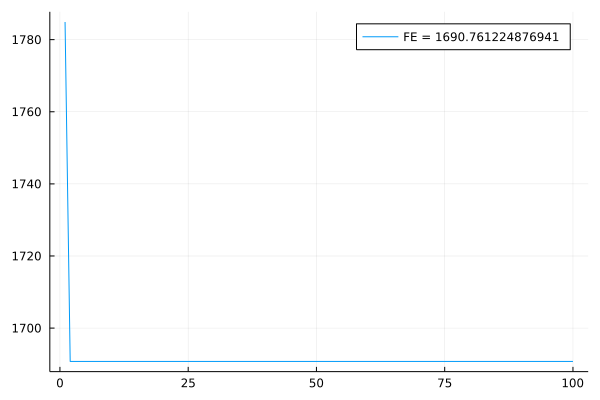

In [51]:
plot(fe_[1:end], label="FE = $(fe_[end])")

In [52]:
from, to = 100, 150

(100, 150)

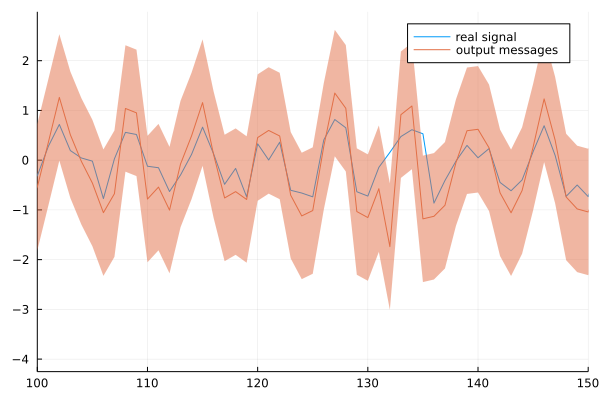

In [53]:
my, vy = mean.(y_out_), cov.(y_out_)
plot(Y_train, xlims=(from, to), label="real signal")
plot!(my, ribbon=sqrt.(vy), label="output messages")

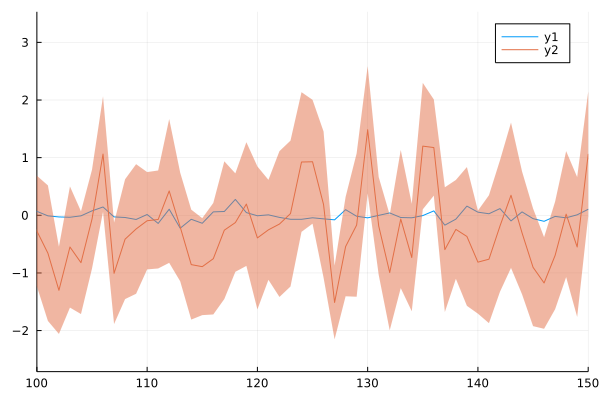

In [54]:
mh, vh = mean.(h_), cov.(h_)
plot(h_gen)
plot!(first.(mh), ribbon=sqrt.(first.(vh)), xlims=(from, to))

### KF-like prediction

In [55]:
function transition(γ, order)
    V = zeros(order, order)
    V[1] = 1/γ
    return V
end

function shift(dim)
    S = Matrix{Float64}(I, dim, dim)
    for i in dim:-1:2
           S[i,:] = S[i-1, :]
    end
    S[1, :] = zeros(dim)
    return S
end

shift (generic function with 1 method)

In [56]:
# Nonlinear MAX model definition
@model [default_factorisation=MeanField()] function nonlinear_max_prediction_model(model_flow::FlowModel, params, w, h_prior, y_prev, u)
    
    dimension = length(h_prior[1])

#     A = shift(dimension) # transition matrix
#     V = transition(w, dimension)

    # initialize variables
    y_pred   = datavar(Float64)
    
    Ys = Y*y_prev
    Us = U*u
    
    del = nr_params(model_flow)
    params_flow = params[1:del]
    params_f = params[del+1:end-2]
    params_w = params[end-1:end]

    h_0 = randomvar() where {form_constraint = FixedMarginalConstraint(NormalMeanPrecision(h_prior[1], h_prior[2]))}

    # compile flow model
    Flow_meta  = FlowMeta(compile(model_flow, params_flow)) # default: FlowMeta(model, Linearization())
    h_0 ~ NormalMeanPrecision(h_prior[1], h_prior[2])
    
#     Ah ~ A*h_0
    h ~ NormalMeanPrecision(h_0, w) where {q = q(h_0, h)q(w)}
    
    hy ~ H*h + Ys
    hyu ~ hy + Us
    
    y_lat_1 ~ Flow(hyu) where { meta = Flow_meta, q = FullFactorisation() }
    
    y_lat_2 ~ dot(y_lat_1, ones(dimension*3))

    y_node, y ~ NormalMeanPrecision(y_lat_2, w) where { q = q(y, y_lat_2)q(w)}
    
    y_pred ~ NormalMeanPrecision(y, 1e-12)
    
    return h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred
end

nonlinear_max_prediction_model (generic function with 1 method)

In [57]:
function nonlinear_max_prediction(observation_prev::T, control::T, model_flow::FlowModel, params; 
                                  h_prior=(ones(2), diageye(2)), w=1.0, vmp_its = 50) where T<:Float64

    # define model
    model, (h, h_0, y_lat_1, y_lat_2, y, y_node, y_pred) = nonlinear_max_prediction_model(model_flow, params, w, h_prior,
                                                                                          observation_prev, control,
                                                                                          options = (limit_stack_depth = 500, ))
    
    h_buffer = nothing
    h0_buffer = nothing
    y_out_buffer = nothing
    y_pred_buffer = nothing
    
    h_sub = subscribe!(getmarginal(h), (x) -> h_buffer = x)
    h0_sub = subscribe!(getmarginal(h_0), (x) -> h0_buffer = x)
    y_pred_sub = subscribe!(getmarginal(y), (x) -> y_pred_buffer = x)

    fe_buffer = Vector()
    
    # subscribe
    fe_sub = subscribe!(score(BetheFreeEnergy(), model), (f) -> push!(fe_buffer, f))
    
    setmarginal!(y, NormalMeanPrecision(0.0, 1.0))
    
    for _ in 1:vmp_its
        ReactiveMP.update!(y_pred, 0.0)
    end
    
    # return the marginal values
    return fe_buffer, h_buffer, h0_buffer, y_pred_buffer
    
end

nonlinear_max_prediction (generic function with 1 method)

In [58]:
predictions = []
h_prev = (mean(h_[end]), precision(h_[end]))
ŵ = mean(w_)
for i in 1:length(X_test)
    fe, h, h_0, y_pred = nonlinear_max_prediction(X_test[i], U_test[i], model_flow, inf_params, h_prior=h_prev, w=ŵ, vmp_its=10)
    push!(predictions, y_pred)
    _, h_inf, _, _, _ = nonlinear_max_inference([Y_test[i]], [X_test[i]], [U_test[i]], model_flow, inf_params, h_prior=h_prev, vmp_its=10);
    h_prev = (mean.(h_inf)[1], precision.(h_inf)[1])
end

In [59]:
mx, vx = mean.(predictions), cov.(predictions)

([-0.7472436764993667, -3.215175470415638, -5.037312897032155, -3.8867859172695254, 4.205229799944152, 11.995859612475492, -0.16074403283599478, -2.494403467572069, -7.775764971239846, -3.8064050543369605  …  -8.384851418682395, -5.777923341679169, -2.08428258499606, 14.098531731161104, 3.2428112491065004, -0.6666868571109029, -7.379583870847045, -12.390799660507572, 0.840837218537299, 3.7463616453744626], [13.597743452553395, 4.849119072692268, 34.83624478549192, 11.322096821890824, 41.387042408361864, 49.845758365692795, 24.283078271946085, 9.682717444661847, 38.85521262566459, 36.808159468035136  …  52.047189618877105, 6.297342738625164, 1.8739669032843664, 48.80470767270966, 37.16215026738334, 30.017834880076858, 52.32177509978937, 44.50804819370424, 26.246979892614462, 42.32456432599049])

In [60]:
test_from, test_to = 150, 200

(150, 200)

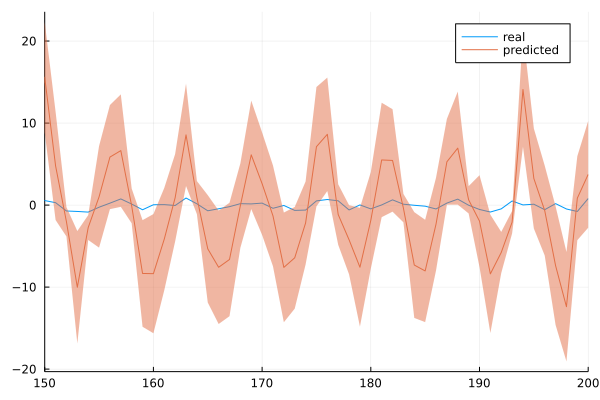

In [61]:
plot(Y_test, label="real")
plot!(mx, ribbon=sqrt.(vx), xlims=(test_from, test_to), label="predicted")